In [28]:
import pandas as pd
import nltk
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [29]:
# /teamspace/studios/this_studio/sentiment_analysis-project
train_data = './sentiment_analysis-project/data/train.csv'
test_data = './sentiment_analysis-project/data/test.csv'
valid_data = './sentiment_analysis-project/data/validation.csv'

file = './sentiment_analysis-project/multiclass_dataset.csv'

def save_load_df(file:str):
    if os.path.exists(file):
        df = pd.read_csv(file, index_col= 0)
    else:
        df = pd.concat(map(pd.read_csv, [train_data, test_data, valid_data]), axis= 0, ignore_index=True)
        df.to_csv(file, columns= ['id', 'text', 'label', 'sentiment'])
        df = pd.read_csv(file, index_col= 0)
    return df

df = save_load_df(file=file)
df

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative
...,...,...,...,...
41639,10277,Fuck no internet damn time warner!,0,negative
41640,8610,Looking forward to android 1.5 being pushed t...,1,neutral
41641,8114,Not good. Wasted time.,0,negative
41642,3034,"U were great, as always. But, can`t we do an ...",2,positive


## TP1, TP2

In [30]:
class PreProcess():
    def __init__(self):
        self.text_pattern = re.compile(
        r'(<.+?>)'         # Balises HTML
        r'(#|@)\w+'  # @ and # words
        r'|([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})'  # Emails
        r'|(https?://[^\s\n\r]+)' # URLs commençant par http ou https
        r'|(www\.[^\s]+)'      # URLs commençant par www
        r'|([\U00010000-\U0010ffff])'  # Émojis et autres caractères au-delà de l'ASCII étendu
        r'|([^\x00-\xFF])'     # Tout ce qui n'est pas en ASCII étendu (0-255)
        )
        self.emoji_pattern = re.compile(
            "[\U0001F600-\U0001F64F"  # Emoticons
            "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
            "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
            "\U0001F700-\U0001F77F"  # Alchemical Symbols
            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            "\U0001FA00-\U0001FA6F"  # Chess Symbols
            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            "\U00002702-\U000027B0"  # Dingbats
            "\U000024C2-\U0001F251"  # Enclosed characters
            "]+",
            flags=re.UNICODE,
        )
        self.punctuation = set(string.punctuation)
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        text = self.text_pattern.sub('', str(text))
        text = self.emoji_pattern.sub('', str(text))
        text = text.lower()
        return text
    
    def get_tokens(self, text):
        text = self.clean_text(text)
        sentences = nltk.sent_tokenize(text)
        tokens = []
        for sentence in sentences:
            words = nltk.word_tokenize(sentence)
            for word in words:
                if word not in self.stop_words:
                    # clean all the punctuation and the StopWords
                    word = ''.join([c for c in word if c not in self.punctuation])
                    if word == '':
                        continue
                    tokens.append(word)
        return tokens

    def lemmetize_with_pos(self, tokens):
        pos_tags = nltk.pos_tag(tokens)
        lemmes = [] 
        pos_tag = []
        for token, pos in pos_tags:
            if pos.startswith('J'):
                lemma = self.lemmatizer.lemmatize(token, pos = 'a')
            elif pos.startswith('V'):
                lemma =  self.lemmatizer.lemmatize(token, pos = 'v')
            elif pos.startswith('RB'):
                lemma = self.lemmatizer.lemmatize(token, pos = 'r')
            elif pos.startswith('N'):
                lemma = self.lemmatizer.lemmatize(token, pos = 'n')
            else:
                lemma = self.lemmatizer.lemmatize(token)
            lemmes.append(lemma)
            pos_tag.append(pos)
        return lemmes, pos_tag
    
    def get_lemmes(self, text):
        tokens = self.get_tokens(text)
        lemmes, _ = self.lemmetize_with_pos(tokens)
        return lemmes
    
    def visualize_data(self, text):
        text = self.clean_text(text)
        tokens = self.get_tokens(text)
        lemmes, pos_tag = self.lemmetize_with_pos(tokens)
        data = [[token, lemme, pos] for token, lemme, pos in zip(tokens, lemmes, pos_tag)]
        return data
    
texts = list(df['text'])
labels = list(df['label'])
process_text = PreProcess()
corpus = pd.DataFrame(data = [(process_text.get_tokens(text), label) for text, label in zip(texts, labels)], columns=['sentence', 'label'])
corpus

,sentence,label
0,"[cooking, microwave, pizzas, yummy]",2
1,"[plans, allowing, sub, tasks, show, widget]",1
2,"[love, humor, reworded, like, saying, group, t...",2
3,"[naw, idk, ur, talkin]",1
4,"[sucks, hear, hate, days, like]",0
...,...,...
41639,"[fuck, internet, damn, time, warner]",0
41640,"[looking, forward, android, 15, pushed, g1]",1
41641,"[good, wasted, time]",0
41642,"[u, great, always, east, germany, noko, least,...",2


In [31]:
# drop the empty rows
corpus = corpus[corpus['sentence'].str.len() != 0]
corpus = corpus.reset_index(drop = True)
corpus

,sentence,label
0,"[cooking, microwave, pizzas, yummy]",2
1,"[plans, allowing, sub, tasks, show, widget]",1
2,"[love, humor, reworded, like, saying, group, t...",2
3,"[naw, idk, ur, talkin]",1
4,"[sucks, hear, hate, days, like]",0
...,...,...
41502,"[fuck, internet, damn, time, warner]",0
41503,"[looking, forward, android, 15, pushed, g1]",1
41504,"[good, wasted, time]",0
41505,"[u, great, always, east, germany, noko, least,...",2


In [32]:
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from gensim.models import KeyedVectors

word2vec_file = './sentiment_analysis-project/GoogleNews-vectors-negative300.bin'
sentences = list(corpus['sentence'])
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file, binary= True)

def sentence_to_vec(sentence):
    sentence_to_vec = [word2vec_model[word] for word in sentence if word in word2vec_model]
    return sentence_to_vec

df1 = pd.DataFrame(data = [(sentence_to_vec(sentence), label) for sentence, label in zip(sentences, list(corpus['label']))], 
                   columns=['vec', 'label'])


In [33]:
df1 = df1[df1['vec'].str.len() != 0]
# df1 = df1.sort_values(by = 'vec', key = lambda vec: vec.str.len(), ascending=False)
df1 = df1.reset_index(drop= True)
df1

,vec,label
0,"[[-0.14160156, 0.25390625, 0.052246094, 0.1279...",2
1,"[[0.15234375, 0.21484375, 0.30273438, 0.000576...",1
2,"[[0.103027344, -0.15234375, 0.025878906, 0.165...",2
3,"[[0.084472656, -0.0625, 0.15625, 0.22167969, 0...",1
4,"[[0.099609375, -0.10839844, 0.049072266, 0.127...",0
...,...,...
41348,"[[0.10449219, -0.3125, 0.21386719, 0.30859375,...",0
41349,"[[0.027832031, 0.25585938, 0.15820312, -0.0480...",1
41350,"[[0.040527344, 0.0625, -0.017456055, 0.0786132...",0
41351,"[[-0.25390625, 0.04663086, 0.1640625, -0.01831...",2


In [34]:
# [len(vec) for vec in list(df1['vec']) if len(vec) <= 64]
df1 = df1[df1['vec'].str.len() <= 64]
df1 = df1.reset_index(drop= True)
df1

,vec,label
0,"[[-0.14160156, 0.25390625, 0.052246094, 0.1279...",2
1,"[[0.15234375, 0.21484375, 0.30273438, 0.000576...",1
2,"[[0.103027344, -0.15234375, 0.025878906, 0.165...",2
3,"[[0.084472656, -0.0625, 0.15625, 0.22167969, 0...",1
4,"[[0.099609375, -0.10839844, 0.049072266, 0.127...",0
...,...,...
41295,"[[0.10449219, -0.3125, 0.21386719, 0.30859375,...",0
41296,"[[0.027832031, 0.25585938, 0.15820312, -0.0480...",1
41297,"[[0.040527344, 0.0625, -0.017456055, 0.0786132...",0
41298,"[[-0.25390625, 0.04663086, 0.1640625, -0.01831...",2


In [35]:
X = pad_sequence([torch.from_numpy(np.array(vec)) for vec in list(df1['vec'])], batch_first=True)
X.shape

torch.Size([41300, 64, 300])

In [36]:
Y = torch.from_numpy(np.array(list(df1['label'])))
Y.shape

torch.Size([41300])

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=42, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, train_size=0.5, random_state=42, shuffle=True)

126147 parameters
epoch 0 || train_loss 1.096, valid_loss 1.085, train_accu 0.359 , valid_accu 0.364, dt= 1.06
epoch 1 || train_loss 1.094, valid_loss 1.085, train_accu 0.371 , valid_accu 0.364, dt= 1.05
epoch 2 || train_loss 1.094, valid_loss 1.085, train_accu 0.371 , valid_accu 0.364, dt= 1.06
epoch 3 || train_loss 1.093, valid_loss 1.076, train_accu 0.378 , valid_accu 0.409, dt= 1.18


epoch 4 || train_loss 1.092, valid_loss 1.085, train_accu 0.379 , valid_accu 0.364, dt= 1.20
epoch 5 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.19
epoch 6 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.23
epoch 7 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.19
epoch 8 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.19
epoch 9 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.22
epoch 10 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.19
epoch 11 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.22
epoch 12 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.22
epoch 13 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 , valid_accu 0.364, dt= 1.19
epoch 14 || train_loss 1.093, valid_loss 1.085, train_accu 0.372 ,

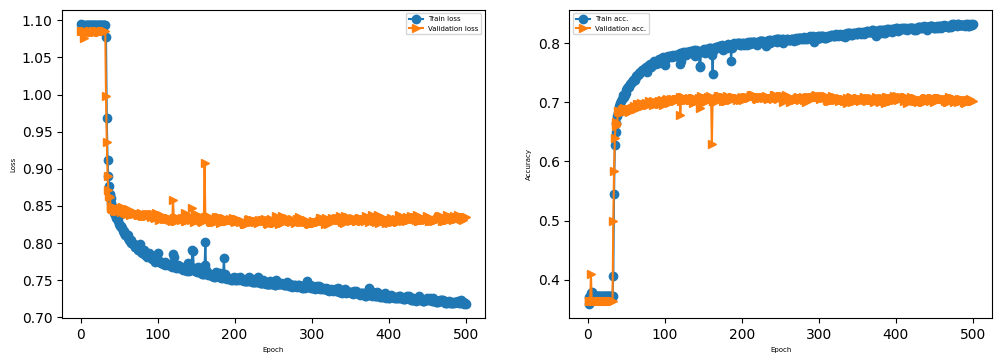

In [39]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
valid_dataset = TensorDataset(x_valid, y_valid)

batch_size = 128
train_dl = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, drop_last=True)
test_dl  = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# (258, 195, 300)
class Model(nn.Module):
    def __init__(self,
                 embed_dim = 300,
                 hidden_size = 64,
                 bidirectional = False,
                 num_layers = 2,
                 dropout = 0.2
        ):
        super(Model, self).__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size= embed_dim,
                            hidden_size = hidden_size,
                            num_layers=num_layers,
                            bias= False,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout
        )
        self.D = 1 if self.bidirectional == False else 2
        self.fc2 = nn.Linear(self.D * hidden_size , 3)

    def forward(self, x):
        B, T, C = x.shape
        out, (h1, c1) = self.lstm(x) 
        out = out[:, -1, :]
        out = F.softmax(self.fc2(out), dim = -1)
        return out

torch.manual_seed(42) # for the distribution of the gradient

torch.set_float32_matmul_precision('high')

model = Model()
model.to(device=device)

optimizer = optim.Adam(model.parameters(), lr = 3e-4)
print(sum(p.numel() for p in model.parameters()),'parameters')

import time

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
num_iter = 500
for i in range(num_iter):
    train_loss = 0
    train_acc = 0
    t1 = time.time()
    model.train()
    for xb_train, yb_train in train_dl:
        optimizer.zero_grad()
        # forward pass
        xb_train = xb_train.to(device)
        yb_train = yb_train.to(device)
        with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
            logits= model(xb_train)
            loss = F.cross_entropy(logits, yb_train)
        # backward pass
        loss.backward()
        train_loss += loss.item() * batch_size
        train_acc += (torch.argmax(logits, dim = 1) == yb_train).float().sum().item()
        # update the gradient
        optimizer.step()

    train_loss /= len(train_dl.dataset)
    train_acc /= len(train_dl.dataset)
     
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for xb_valid, yb_valid in valid_dl:
            xb_valid = xb_valid.to(device)
            yb_valid = yb_valid.to(device)
            logits = model(xb_valid)
            loss = F.cross_entropy(logits, yb_valid)
            valid_loss += loss.item() * batch_size
            valid_acc += (torch.argmax(logits, dim = 1) == yb_valid).float().sum().item()
    
    valid_loss /= len(valid_dl.dataset)
    valid_acc /= len(valid_dl.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    t2 = time.time()
    dt = (t2 - t1)
    print(f'epoch {i} || train_loss {train_loss:.3f}, valid_loss {valid_loss:.3f}, train_accu {train_acc:.3f} , valid_accu {valid_acc:.3f}, dt= {dt:.2f}')

import matplotlib.pyplot as plt

x_arr = np.arange(num_iter) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_losses, '-o', label='Train loss')
ax.plot(x_arr, valid_losses, '->', label='Validation loss')
ax.legend(fontsize=5)
ax.set_xlabel('Epoch', size=5)
ax.set_ylabel('Loss', size=5)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, train_accuracies, '-o', label='Train acc.')
ax.plot(x_arr, valid_accuracies, '->', label='Validation acc.')
ax.legend(fontsize=5)
ax.set_xlabel('Epoch', size=5)
ax.set_ylabel('Accuracy', size=5)

plt.show()

In [40]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

test_acc = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for xb_test, yb_test in test_dl:
        xb_test = xb_test.to(device)
        yb_test = yb_test.to(device)
        logits = model(xb_test)
        pred = torch.argmax(logits, dim = 1)
        test_acc += (pred == yb_test).float().sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb_test.cpu().numpy())

test_acc /= len(test_dl.dataset)
precision = precision_score(all_labels, all_preds, average='weighted')  # 'weighted' pour pondérer selon les classes
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print('test accuracy', test_acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

test accuracy 0.712590799031477
Precision: 0.7174182732884747
Recall: 0.712590799031477
F1-Score: 0.7138044132184673

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69      1213
           1       0.67      0.66      0.67      1509
           2       0.82      0.76      0.79      1408

    accuracy                           0.71      4130
   macro avg       0.72      0.71      0.71      4130
weighted avg       0.72      0.71      0.71      4130



In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# train_dataset = TensorDataset(x_train, y_train)
# test_dataset = TensorDataset(x_test, y_test)
# valid_dataset = TensorDataset(x_valid, y_valid)

# batch_size = 128
# train_dl = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, drop_last=True)
# valid_dl = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
# test_dl  = DataLoader(test_dataset, batch_size= batch_size, shuffle=True, drop_last= True)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # (258, 195, 300)
# class Model(nn.Module):
#     def __init__(self,
#                  embed_dim = 300,
#                  hidden_size = 128,
#                  bidirectional = False,
#                  num_layers = 1,
#                  dropout = 0.2
#         ):
#         super(Model, self).__init__()
#         self.bidirectional = bidirectional
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size= embed_dim,
#                             hidden_size = hidden_size,
#                             num_layers=num_layers,
#                             bias= False,
#                             bidirectional=bidirectional,
#                             batch_first=True,
#                             # dropout=dropout
#         )
#         self.D = 1 if self.bidirectional == False else 2
#         self.fc2 = nn.Linear(self.D * hidden_size , 3)

#     def forward(self, x):
#         B, T, C = x.shape
#         out, (h1, c1) = self.lstm(x)
#         out = F.softmax(self.fc2(out), dim = -1)
#         return out

# torch.manual_seed(42) # for the distribution of the gradient

# torch.set_float32_matmul_precision('high')

# model = Model()
# model.to(device=device)
# # model = torch.compile(model)

# optimizer = optim.Adam(model.parameters(), lr = 3e-4)
# print(sum(p.numel() for p in model.parameters()),'parameters')

# import time
# num_iter = 200
# for i in range(num_iter):
#     train_loss = 0
#     train_acc = 0
#     t1 = time.time()
#     model.train()
#     for xb_train, yb_train in train_dl:
#         optimizer.zero_grad()
#         # forward pass
#         xb_train = xb_train.to(device)
#         yb_train = yb_train.to(device)
#         with torch.autocast(device_type = 'cuda', dtype = torch.float16):
#             logits= model(xb_train)[:, -1, :]
#             loss = F.cross_entropy(logits, yb_train)
#         # backward pass
#         loss.backward()
#         train_loss += loss.item() * batch_size
#         train_acc += (torch.argmax(logits, dim = 1) == yb_train).float().sum().item()
#         # update the gradient
#         optimizer.step()

#     train_loss /= len(train_dl.dataset)
#     train_acc /= len(train_dl.dataset)
     
#     model.eval()
#     valid_loss = 0
#     valid_acc = 0
#     with torch.no_grad():
#         for xb_valid, yb_valid in valid_dl:
#             xb_valid = xb_valid.to(device)
#             yb_valid = yb_valid.to(device)
#             logits = model(xb_valid)[:, -1, :]
#             loss = F.cross_entropy(logits, yb_valid)
#             valid_loss += loss.item() * batch_size
#             valid_acc += (torch.argmax(logits, dim = 1) == yb_valid).float().sum().item()
    
#     valid_loss /= len(valid_dl.dataset)
#     valid_acc /= len(valid_dl.dataset)
#     t2 = time.time()
#     dt = (t2 - t1)
#     print(f'epoch {i} || train_loss {train_loss:.3f}, valid_loss {valid_loss:.3f}, train_accu {train_acc:.3f} , valid_accu {valid_acc:.3f}, dt= {dt:.2f}')